In [1]:
from torch_geometric.data import DataLoader
import torch.distributions as D
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolTransforms
from rdkit import rdBase
import glob
import os

from deepdock.utils.distributions import *
from deepdock.utils.data import *
from deepdock.models import *

from deepdock.DockingFunction import optimze_conformation
from scipy.optimize import basinhopping, brute, differential_evolution
import copy

# set the random seeds for reproducibility
np.random.seed(123)
torch.cuda.manual_seed_all(123)
torch.manual_seed(123)

%matplotlib inline

RDKit WARNING: [12:00:22] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

ligand_model = LigandNet(28, residual_layers=10, dropout_rate=0.10)
target_model = TargetNet(4, residual_layers=10, dropout_rate=0.10)
model = DeepDock(ligand_model, target_model, hidden_dim=64, n_gaussians=10, dropout_rate=0.10, dist_threhold=7.).to(device)

checkpoint = torch.load('../Trained_models/DeepDock_pdbbindv2019_13K_minTestLoss.chk')
model.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

In [3]:
%%time
db_complex = PDBbind_complex_dataset(data_path='../data/dataset_deepdock_pdbbind_v2019_16K.tar', 
                                     min_target_nodes=50, max_ligand_nodes=None)
db_complex = [i for i in db_complex if i[3] in checkpoint['pdbIDs_test']]
print('Complexes in Test Set:', len(db_complex))


Complexes in Test Set: 1367
CPU times: user 4.9 s, sys: 2.61 s, total: 7.51 s
Wall time: 7.51 s


In [4]:
def dock_compound(data, dist_threshold=3., popsize=150):
    np.random.seed(123)
    torch.cuda.manual_seed_all(123)
    torch.manual_seed(123)
    
    model.eval()
    ligand, target, activity, pdbid = data
    ligand, target = ligand.to(device), target.to(device)
    pi, sigma, mu, dist, atom_types, bond_types, batch = model(ligand, target)
    
    pdb_id = pdbid[0]
    real_mol = Chem.MolFromMol2File('../../DeepDock/data/pdbbind_v2019_other_refined/' + pdb_id + '/' + pdb_id +'_ligand.mol2',
                                    sanitize=False, cleanupSubstructures=False, removeHs=False)
    opt = optimze_conformation(mol=real_mol, target_coords=target.pos.cpu(), n_particles=1, 
                               pi=pi.cpu(), mu=mu.cpu(), sigma=sigma.cpu(), dist_threshold=dist_threshold)
    
    #Define bounds
    max_bound = np.concatenate([[np.pi]*3, target.pos.cpu().max(0)[0].numpy(), [np.pi]*len(opt.rotable_bonds)], axis=0)
    min_bound = np.concatenate([[-np.pi]*3, target.pos.cpu().min(0)[0].numpy(), [-np.pi]*len(opt.rotable_bonds)], axis=0)
    bounds = (min_bound, max_bound)
    
    # Optimize conformations
    result = differential_evolution(opt.score_conformation, list(zip(bounds[0],bounds[1])), maxiter=500, 
                                    popsize=int(np.ceil(popsize/(len(opt.rotable_bonds)+6))),
                                    mutation=(0.5, 1), recombination=0.8, disp=False, seed=123)
    
    # Get optimized molecule and RMSD
    opt_mol = opt.apply_changes(opt.mol, result['x'])
    ligCoords = torch.stack([torch.tensor(m.GetConformer().GetPositions()[opt.noHidx]) for m in [opt_mol]])
    dist = opt.compute_euclidean_distances_matrix(ligCoords, opt.targetCoords).flatten().unsqueeze(1)
    result['num_MixOfGauss'] = torch.where(dist <= dist_threshold)[0].size(0)
    result['rmsd'] = Chem.rdMolAlign.AlignMol(opt_mol, real_mol, atomMap=list(zip(opt.noHidx,opt.noHidx)))
    result['pdb_id'] = pdb_id
    
    # Get score of real conformation
    ligCoords = torch.stack([torch.tensor(m.GetConformer().GetPositions()[opt.noHidx]) for m in [real_mol]])
    dist = opt.compute_euclidean_distances_matrix(ligCoords, opt.targetCoords).flatten().unsqueeze(1)
    score_real_mol = opt.calculate_probablity(opt.pi, opt.sigma, opt.mu, dist)
    score_real_mol[torch.where(dist > dist_threshold)[0]] = 0.
    result['score_real_mol'] = pdb_id = score_real_mol.reshape(opt.n_particles, -1).sum(1).item()
    del ligCoords, dist, score_real_mol
    
    result['pkx'] = data[2][0].item()
    result['num_atoms'] = real_mol.GetNumHeavyAtoms()
    result['num_rotbonds'] = len(opt.rotable_bonds)
    result['rotbonds'] = opt.rotable_bonds
    #result['num_MixOfGauss'] = mu.size(0)
    
    return result

In [ ]:
%%time
loader = DataLoader(db_complex, batch_size=1, shuffle=False)

results = []
i = 0
for data in loader:
    try:
        results.append(dock_compound(data))
        d = {}
        for k in results[0].keys():
            if k != 'jac':
                d[k] = tuple(d[k] for d in results)
        torch.save(d, 'DockingResults_TestSet.chk')
        results_df = pd.DataFrame.from_dict(d)
        results_df.to_csv('DockingResults_TestSet.csv', index=False) 
        i += 1
    except:
        print(i, data[3])
        #break
        i += 1

RDKit WARNING: [18:41:01] 1w70_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


In [6]:
results_df.head()

,x,fun,nfev,nit,message,success,num_MixOfGauss,rmsd,pdb_id,score_real_mol,pkx,num_atoms,num_rotbonds,rotbonds
0,"[0.4068741664658634, -3.111903377819833, 2.669...",[-61.60544253382419],81378,500,Maximum number of iterations has been exceeded.,False,428,2.892180,3zsq,85.058905,4.96,39,14,"[(2, 10, 20, 31), (14, 11, 21, 33), (5, 12, 30..."
1,"[-2.0860038481249803, 0.36174218280227977, -0....",-204.159,8093,51,Optimization terminated successfully.,True,273,2.222657,6g34,192.097119,8.24,20,2,"[(3, 2, 1, 0), (6, 5, 4, 3)]"
2,"[1.1728373648793995, 1.711938601173987, 2.2464...",[-104.11306138437084],21802,134,Optimization terminated successfully.,True,469,1.667209,5w99,97.692953,4.68,34,7,"[(18, 1, 0, 15), (27, 26, 2, 18), (5, 4, 6, 24..."
3,"[0.6677677050421503, -1.6613927144064407, -0.6...",[-4.350164062386345],33354,212,Optimization terminated successfully.,True,117,0.569976,2q7q,1.262541,5.30,9,1,"[(3, 2, 1, 0)]"
4,"[-1.1667280590125937, 0.0006917577322102169, -...",[-100.44115467231256],33998,212,Optimization terminated successfully.,True,315,2.894431,2pbw,95.071165,8.25,22,7,"[(0, 1, 3, 4), (1, 3, 5, 6), (5, 6, 7, 8), (11..."


(array([153., 187., 158., 108.,  80.,  65.,  62.,  40.,  35.,  29.]),
 array([ 28. ,  75.1, 122.2, 169.3, 216.4, 263.5, 310.6, 357.7, 404.8,
        451.9, 499. ]),
 <a list of 10 Patch objects>)

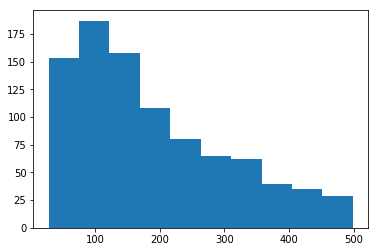

In [7]:
plt.hist(results_df['nit'][results_df.success == True])

(array([287., 491., 255., 142.,  76.,  61.,  39.,   7.,   6.,   3.]),
 array([1.99216067e-06, 1.12116077e+00, 2.24231954e+00, 3.36347832e+00,
        4.48463709e+00, 5.60579587e+00, 6.72695465e+00, 7.84811342e+00,
        8.96927220e+00, 1.00904310e+01, 1.12115897e+01]),
 <a list of 10 Patch objects>)

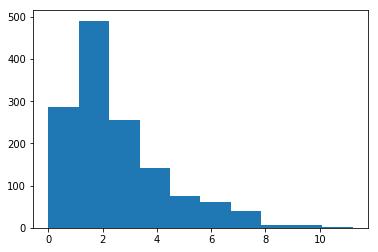

In [21]:
#plt.hist(results_df['rmsd'][results_df.success == True])
plt.hist(results_df['rmsd'])

In [22]:
results_df.rmsd.mean()

2.495132448184889

In [8]:
results_df[results_df.success == True].rmsd.mean()

1.6241036200685184

In [9]:
results_df[results_df.success == True].shape

(917, 14)

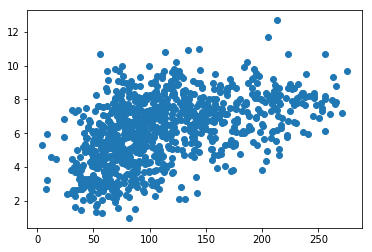

In [10]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(norm_scores, results_df[results_df.success == True].pkx)

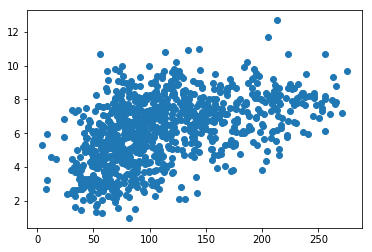

In [28]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(norm_scores, results_df[results_df.success == True].pkx)

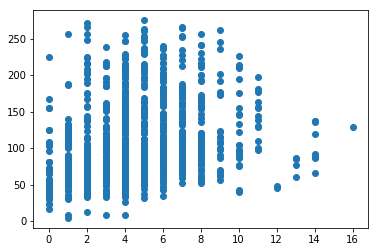

In [12]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(results_df[results_df.success == True].num_rotbonds, norm_scores)

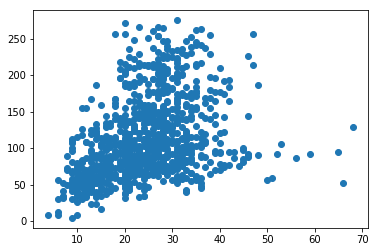

In [13]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(results_df[results_df.success == True].num_atoms, norm_scores)

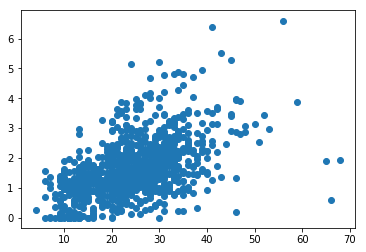

In [14]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(results_df[results_df.success == True].num_atoms, results_df[results_df.success == True].rmsd)

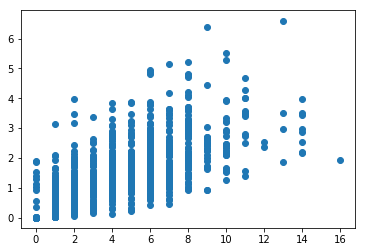

In [19]:
plt.scatter(results_df[results_df.success == True].num_rotbonds, results_df[results_df.success == True].rmsd)
#plt.scatter(results_df.num_rotbonds, results_df.rmsd)

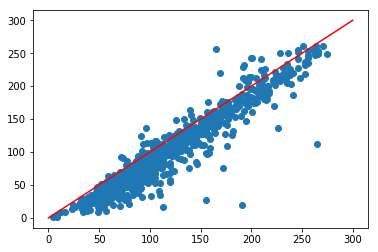

In [17]:
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in results_df.fun[results_df.success == True]]
plt.scatter(norm_scores, results_df[results_df.success == True].score_real_mol)
plt.plot([0,300], [0,300], '-r')

In [18]:
d = torch.load('DockingResults_TestSet.chk')
reults_df = pd.DataFrame.from_dict(d)
reults_df.head()

,x,fun,nfev,nit,message,success,jac,rmsd,pdb_id,score_real_mol
0,"[1.3748057943281191, -0.4826028014294825, 2.13...",[-364.806770723242],7362,56,Optimization terminated successfully.,True,"[-0.0021884716261411086, -0.001716671249596402...",1.062297,3wf6,627.400509
1,"[3.141592653589793, -1.4331719131845528, -2.52...",[-493.99769349980284],117589,500,Maximum number of iterations has been exceeded.,False,"[-0.6910909178259317, 0.0010231815394945443, -...",3.542217,4b9z,782.277607
2,"[-2.109265052871724, 0.3173394855975662, -2.09...",[-1162.5185396000136],240454,500,Maximum number of iterations has been exceeded.,False,"[31.426748137164395, 24.671612663951237, -32.6...",3.126936,1m0b,1604.583213
3,"[-0.15389043897876434, -3.020332654441904, 1.7...",[-74.78615502978923],3666,33,Optimization terminated successfully.,True,"[-0.00011368683772161603, 1.1368683772161603e-...",0.053483,2rk7,60.809820
4,"[-0.8998916306504124, -0.8213899634576136, -0....",[-422.6319121543464],34527,135,Optimization terminated successfully.,True,"[-0.0023362645151792094, 0.01262492332898546, ...",4.171069,4wkp,273.228510


In [ ]:
#%%time
#loader = DataLoader(db_complex_train[5:1000], batch_size=1, shuffle=False)
#data =  next(iter(loader))

pdb_id = data[3][0]
real_mol = Chem.MolFromMol2File('data/pdbbind_v2019_other_refined/' + pdb_id + '/' + pdb_id +'_ligand.mol2')
mol = Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromMol2File('data/pdbbind_v2019_other_refined/' + pdb_id + '/' + pdb_id +'_ligand.mol2')))
Chem.rdchem.Mol.Compute2DCoords(mol)
Chem.rdMolTransforms.CanonicalizeConformer(mol.GetConformer())
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, randomSeed=123)
AllChem.MMFFOptimizeMolecule(mol)
mol = Chem.RemoveHs(mol)


opt = optimze_conformation(mol=mol, target_coords=torch.tensor([0]), n_particles=1, pi=torch.tensor([0]), mu=torch.tensor([0]), sigma=torch.tensor([0]))


opt_mol = copy.copy(mol)
values = t['x']
        
# aplply rotations
[opt.SetDihedral(opt_mol.GetConformer(), opt.rotable_bonds[r], values[6+r]) for r in range(len(opt.rotable_bonds))]
        
# aplply transformation matrix
rdMolTransforms.TransformConformer(opt_mol.GetConformer(), opt.GetTransformationMatrix(values[:6]))
opt_mol


In [ ]:
import py3Dmol
p = py3Dmol.view(width=400,height=400)
p.addModel(Chem.MolToMolBlock(opt_mol),'sdf')
p.addModel(Chem.MolToMolBlock(real_mol),'sdf')
p.setStyle({'stick':{}})
p.zoomTo()

p.show()